In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.path import Path

#from IPython.display import clear_output
#from IPython.display import SVG

In [9]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [10]:
get_available_gpus()

[]

# Import binary data

In [11]:
data = np.fromfile("/home/philip/RemoteFNAL/PanLee_v8_00_00_13/OutTest/viewV_May30.bin", dtype=np.float32)
dataPanReco = np.fromfile("/home/philip/RemoteFNAL/PanLee_v8_00_00_13/OutTest/PandoraRecoV_May30.bin", dtype=np.float32)
print(np.shape(data), np.shape(dataPanReco))

(3009225,) (1890183,)


In [12]:
#data[0:100]

In [13]:
ss = np.where(data==-1.22)[0]
ssPR = np.where(dataPanReco==-1.22)[0]
print(np.shape(ss))

(1521,)


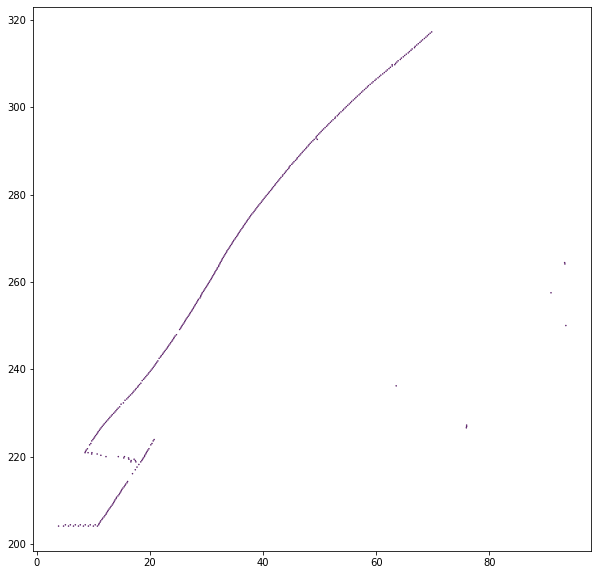

In [14]:
# 9, 10, 11?

i = 197

minX = data[1+ss[i]]
minZ = data[2+ss[i]]
x = data[3+ss[i]:ss[i+1]:6]
z = data[4+ss[i]:ss[i+1]:6]
E = data[5+ss[i]:ss[i+1]:6]
s = data[6+ss[i]:ss[i+1]:6]
p = data[7+ss[i]:ss[i+1]:6]
o = data[8+ss[i]:ss[i+1]:6]

plt.figure(figsize=(10,10))
plt.scatter(x, z, c=(1.5*s+p), s=1, marker=".")
plt.show()
#print(np.sum(snPR),np.sum(soPR),np.sum(tnPR),np.sum(toPR))


In [15]:
sSum=0
pSum=0
oSum=0
for i in range(np.size(ss)-1):
    s = data[6+ss[i]:ss[i+1]:6]
    p = data[7+ss[i]:ss[i+1]:6]
    o = data[8+ss[i]:ss[i+1]:6]
    
    sSum += np.size(s[s>0.5])
    pSum += np.size(p[p>0.5])
    oSum += np.size(o[o>0.5])

print("Shower" ,sSum/(sSum+pSum+oSum))
print("Track" ,pSum/(sSum+pSum+oSum))
print("Other" ,oSum/(sSum+pSum+oSum))

Shower 0.4258513972081801
Track 0.06929817027744434
Other 0.5048504325143756


0.0 16.0 0.0 0.0


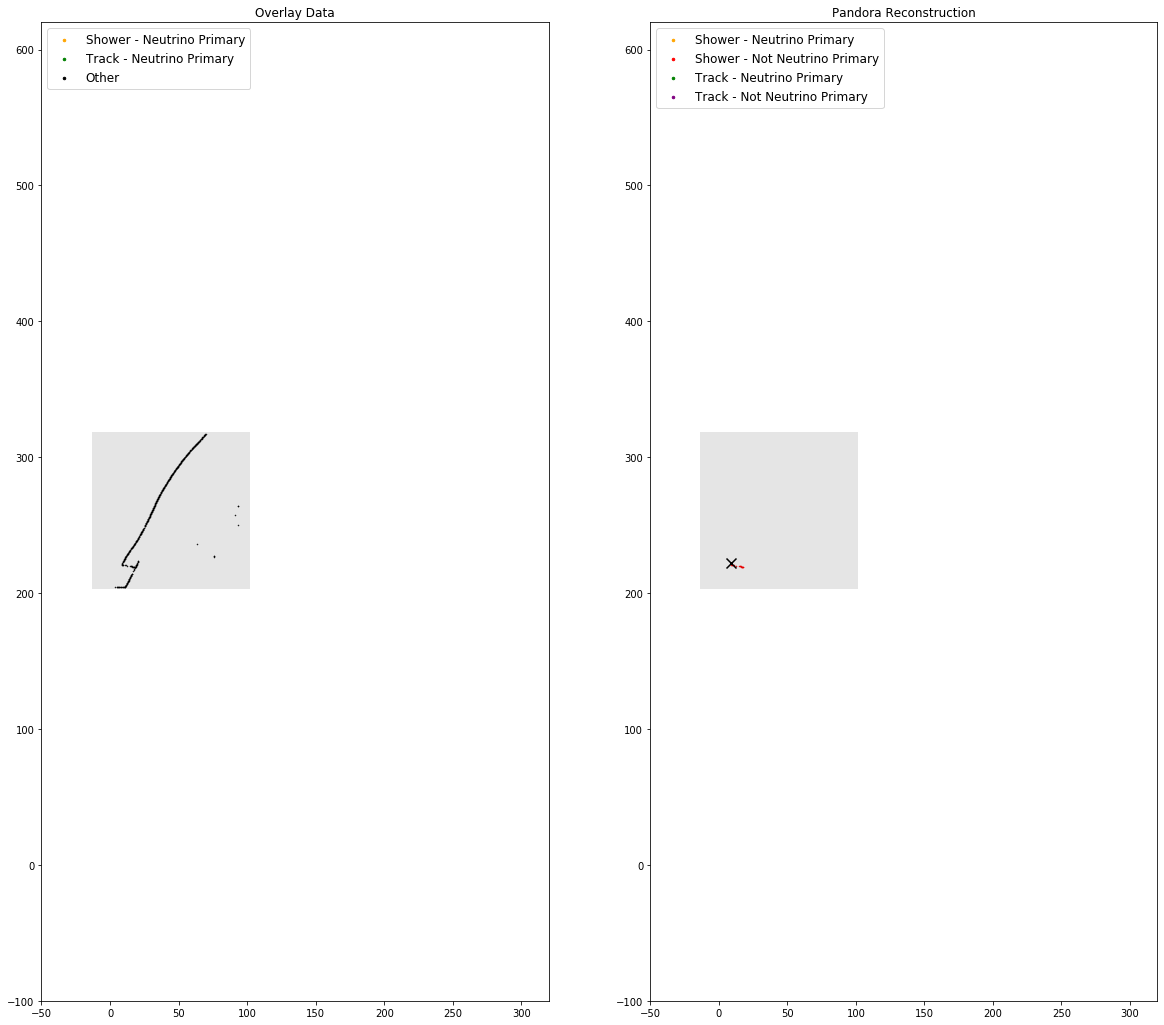

In [16]:
# Photos: 19
# Problems: 5, 10, 11, ,25, 37
# 20, 27
i = 197

minX = data[1+ss[i]]
minZ = data[2+ss[i]]
x = data[3+ss[i]:ss[i+1]:6]
z = data[4+ss[i]:ss[i+1]:6]
E = data[5+ss[i]:ss[i+1]:6]
s = data[6+ss[i]:ss[i+1]:6]
p = data[7+ss[i]:ss[i+1]:6]
o = data[8+ss[i]:ss[i+1]:6]


vertexX = dataPanReco[1+ssPR[i]]
vertexZ = dataPanReco[2+ssPR[i]]
xPR = dataPanReco[3+ssPR[i]:ssPR[i+1]:6]
zPR = dataPanReco[4+ssPR[i]:ssPR[i+1]:6]
snPR = dataPanReco[5+ssPR[i]:ssPR[i+1]:6] # Reconstructed as shower, neutrino final state
soPR = dataPanReco[6+ssPR[i]:ssPR[i+1]:6] # Reconstructed as shower, not identified as neutrino final state
tnPR = dataPanReco[7+ssPR[i]:ssPR[i+1]:6] # Reconstructed as track, neutrino final state
toPR = dataPanReco[8+ssPR[i]:ssPR[i+1]:6] # Reconstructed as track, not identified as neutrino final state


# mask = np.where(o<0.85)
#fig, ax = plt.subplots(figsize=(7.5,15))

plt.figure(figsize=(20,18))
ax = plt.subplot(1,2,1)
#plt.scatter(x, z, c=(1.5*s+p), s=2, marker=",")


ax.scatter(x[s>0.1], z[s>0.1], c="orange", s=1, marker=".", label='Shower - Neutrino Primary')
ax.scatter(x[p>0.1], z[p>0.1], c="green", s=1, marker=".", label='Track - Neutrino Primary')
ax.scatter(x[o>0.1], z[o>0.1], c="black", s=1, marker=".", label='Other')

rect = plt.Rectangle((minX+1,minZ+1),384*0.3,384*0.3, facecolor="black", alpha=0.1)
ax.add_patch(rect)
ax.set_title("Overlay Data")
ax.set_xlim([-50,320])
ax.set_ylim([-100,620])
plt.legend(loc='upper left', fontsize='large', markerscale=5);

print(np.sum(snPR),np.sum(soPR),np.sum(tnPR),np.sum(toPR))

ax = plt.subplot(1,2,2)
ax.scatter(xPR[snPR>0], zPR[snPR>0], c="orange", s=1, marker=".", label='Shower - Neutrino Primary')
ax.scatter(xPR[soPR>0], zPR[soPR>0], c="red", s=1, marker=".", label='Shower - Not Neutrino Primary')
ax.scatter(xPR[tnPR>0], zPR[tnPR>0], c="green", s=1, marker=".", label='Track - Neutrino Primary')
ax.scatter(xPR[toPR>0], zPR[toPR>0], c="purple", s=1, marker=".", label='Track - Not Neutrino Primary')
ax.scatter(vertexX,vertexZ, s=100, c='black', marker='x')
rect = plt.Rectangle((minX+1,minZ+1),384*0.3,384*0.3, facecolor="black", alpha=0.1)
ax.add_patch(rect)
ax.set_title("Pandora Reconstruction")
ax.set_xlim([-50,320])
ax.set_ylim([-100,620])
plt.legend(loc='upper left', fontsize='large', markerscale=5);
#plt.colorbar()
#plt.savefig('Cropping6.png')
plt.show()

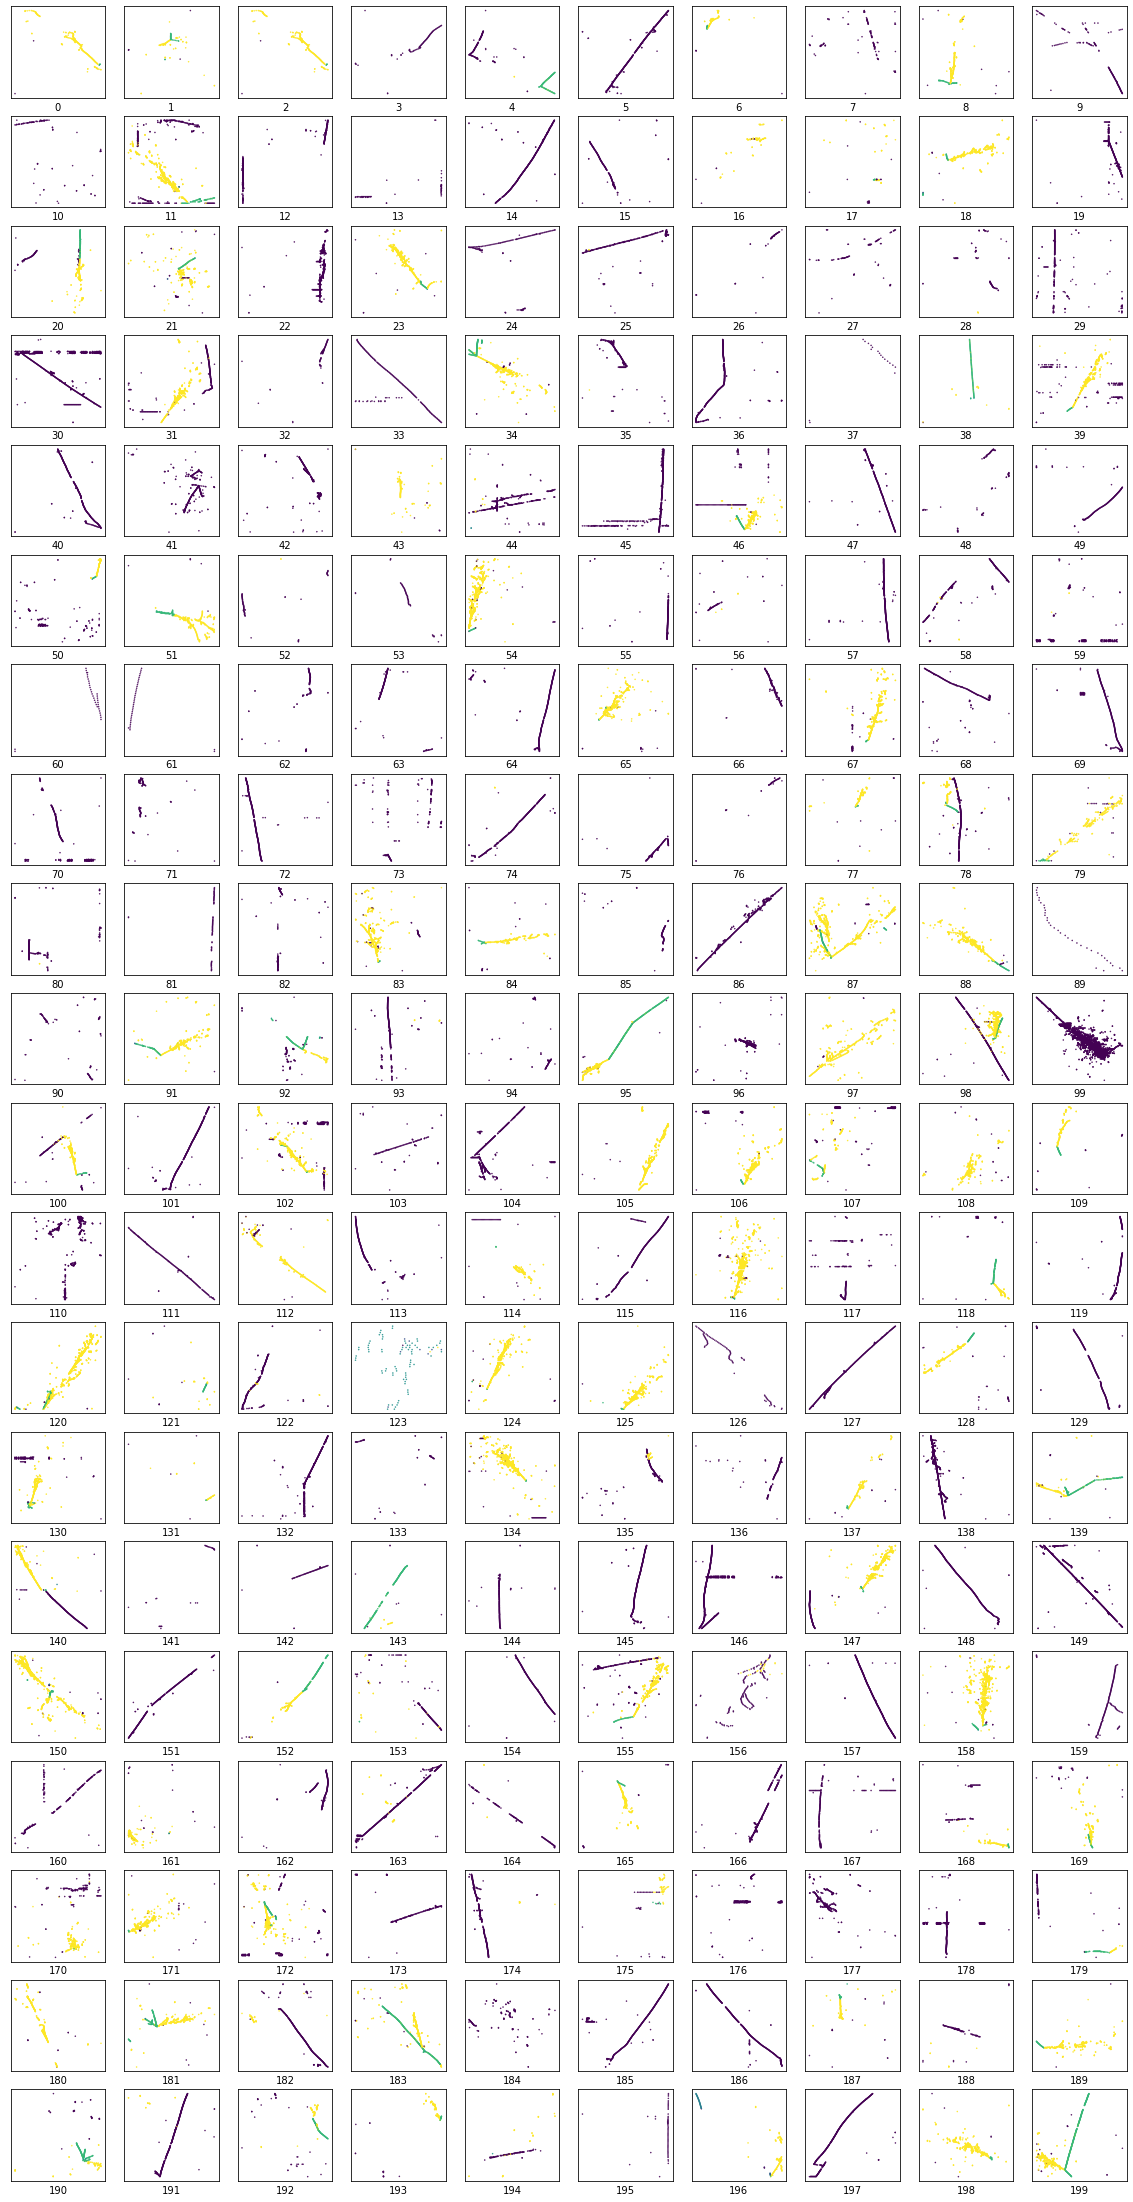

In [17]:
plt.figure(figsize=(20,40))
for i in range(200):
    minX = data[1+ss[i]]
    minZ = data[2+ss[i]]
    x = data[3+ss[i]:ss[i+1]:6]-minX
    z = data[4+ss[i]:ss[i+1]:6]-minZ 
    s = data[6+ss[i]:ss[i+1]:6]
    p = data[7+ss[i]:ss[i+1]:6]
    
    xMask = np.bitwise_and(x<384*0.3, x>0)
    zMask = np.bitwise_and(z<384*0.3, z>0)
    mask = np.bitwise_and(xMask, zMask)
    x = x[mask]
    z = z[mask]
    s = s[mask]
    p = p[mask]
    
    ax = plt.subplot(20,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.scatter(x, z, c=(1.5*s+p), s=1, marker=".")
    plt.xlabel(i)
    
    if(minZ==0 and minX==0):#<0.1 and minZ>-0.1 and minX<0.1 and minX>-0.1):
        rect = plt.Rectangle((0,0),384*0.3,384*0.3, facecolor="red", alpha=0.1)
        ax.add_patch(rect)
plt.show()


# Other

In [150]:
IMSIZE = 384
FRAME_NUM = int(np.size(data)/(IMSIZE*IMSIZE*4))
reshaped_data = data.reshape((FRAME_NUM, IMSIZE,IMSIZE,4))
frames = tf.expand_dims(reshaped_data[:,:,:,0],3) # expand_dim: (x,256,256) -> (x,256,256,1)
masks = reshaped_data[:,:,:,1:]

ValueError: cannot reshape array of size 128496 into shape (0,256,256,4)

In [10]:
def normalize(input_frame, input_mask):
    input_frame = tf.cast(input_frame, tf.float16) / 255.0
    input_mask = tf.cast(input_mask, tf.float16)/255.0
    return input_frame, input_mask

@tf.function
def load_frame(frame, mask):
    frame, mask = normalize(frame, mask)
    return frame, mask

In [11]:
#TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
n = 4*FRAME_NUM//5 # Split percentage
train_dataset = tf.data.Dataset.from_tensor_slices((frames[:n], masks[:n]))
test_dataset = tf.data.Dataset.from_tensor_slices((frames[n:], masks[n:]))

In [13]:
train = train_dataset.map(load_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_frame)

In [14]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# Display Data

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Frame', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(frame[,,:0])
        plt.axis('off')
    plt.show()

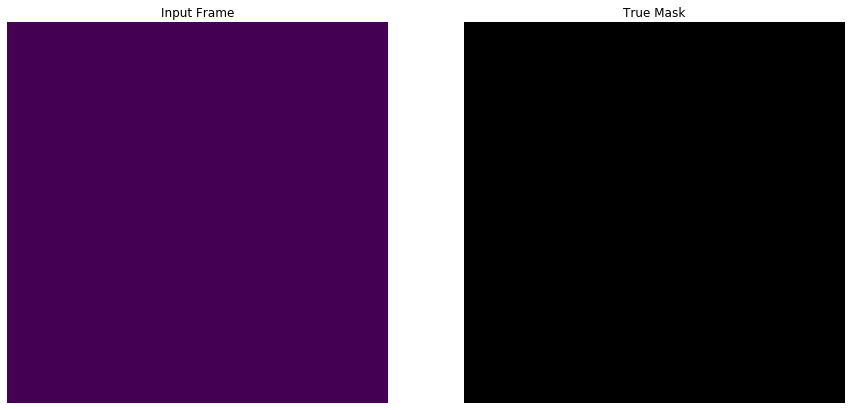

In [18]:
for frame, mask in train.take(1):
    sample_frame, sample_mask = frame, mask
display([sample_frame, sample_mask])

# ResNet Layer Definition

In [19]:
# Adapted from https://keras.io/examples/cifar10_resnet/

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = tf.keras.layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
        x = conv(x)
    return x

In [20]:
def downsample(filters, size, strides=1, activation=True):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

    result.add(tf.keras.layers.BatchNormalization())
    
    if activation:
        result.add(tf.keras.layers.ReLU())
    return result

SyntaxError: invalid syntax (<ipython-input-20-10730f74442d>, line 4)

In [ ]:
def down_residual_block(filters, kernel_size, downsampling=True):
    result = tf.keras.Sequential()
    
    if(downsampling) stride = 2
    else stride = 1
    
    for i in range(3):
        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=stride,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=1,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ReLU())
        stride = 1
    return result

In [ ]:
down_stack = [
    down_residual_block(16, 3),
    down_residual_block(32, 3),
    down_residual_block(64, 3),
    down_residual_block(128, 3),
    down_residual_block(256, 3, downsampling=False),
]

# Upsample Layer Definition

In [ ]:
def upsample(filters, size):

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def up_residual_block(filters, kernel_size, downsampling=True):
    result = tf.keras.Sequential()
    
    if(downsampling) stride = 2
    else stride = 1
    
    for i in range(3):
        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=stride,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.Conv2D(filters, kernel_size
                      strides=1,
                      padding='same',
                      kernel_initializer='he_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ReLU())
        stride = 1
    return result

In [ ]:
up_stack = [
    upsample(256, 3),  # 4x4 -> 8x8
    upsample(128, 3),  # 8x8 -> 16x16
    upsample(64, 3),  # 16x16 -> 32x32
    upsample(32, 3),   # 32x32 -> 64x64
    #upsample(16, 3),
]

# U-Net Model Definition

In [14]:
OUTPUT_CHANNELS = 3

In [25]:
def u_resnet(output_channels, depth):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44)')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)    
    skips = [None]*5
    
    # Instantiate the stack of residual units
    conv1 = tf.keras.layers.Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    
    conv2 = tf.keras.layers.Conv2D(num_filters,
              kernel_size=3,
              strides=2,
              padding='same',
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    
    convTrans = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=3, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False)
    concat = tf.keras.layers.Concatenate()
    
    
    ####### Beginning of U-ResNet #######
    #####################################
    inputs = tf.keras.layers.Input(shape=[IMSIZE, IMSIZE, 1])
    x = conv1(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(y)
    x = tf.keras.layers.Activation('relu')(y)
    
    
    
    ####### Beginning of Downsampling ResNet
    for stack in range(5):
        for res_block in range(num_res_blocks):
            doDownsample = (stack > 0 and res_block == 0) # first layer but not first stack           
            y = conv2(x) if doDownsample else conv1(x)
            y = tf.keras.layers.BatchNormalization()(y)
            y = tf.keras.layers.Activation('relu')(y)
            y = conv1(y)
            y = tf.keras.layers.BatchNormalization()(y)
            if doDownsample: # linear projection residual shortcut connection to match changed dims
                x = tf.keras.layers.Conv2D(num_filters, kernel_size=1, strides=2, 
                                           padding='same', kernel_initializer='he_normal', 
                                           kernel_regularizer=tf.keras.regularizers.l2(1e-4))

            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        skips[stack] = x
        num_filters *= 2
    ####### End of Downsampling ResNet
    
    ####### Beginning of Upsampling ResNet
    for stack in range(4):
        for res_block in range(num_res_blocks):
            doUpsample = (stack < 4 and res_block == 0) # first layer but not last stack            
            if doUpsample:
                x = convTrans(x)
                y = concat([x, skips[-(stack+1)]])    
            else:
                conv1(x)
            y = tf.keras.layers.BatchNormalization()(y)
            y = tf.keras.layers.Activation('relu')(y)
            y = conv1(y)
            y = tf.keras.layers.BatchNormalization()(y)
            if doUpsample: # linear projection residual shortcut connection to match changed dims
                x = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=1, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False)

            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        num_filters /= 2
    ####### End of Upsampling ResNet
    
  
    ####### Last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [46]:
def u_resnet(output_channels, depth):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44)')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    
    inputs = tf.keras.layers.Input(shape=[IMSIZE, IMSIZE, 1])
    x = resnet_layer(inputs=inputs)
    
    skips = [None]*5
    
    # Instantiate the stack of residual units
    for stack in range(5):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        skips[stack] = x
        num_filters *= 2
    
    skips = reversed(skips[:-1])
    skips = []

    # Instantiate the stack of residual units
    for stack in range(5):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        skips[stack] = x
        num_filters *= 2
    
    
    
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        print(x)

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [47]:
#print(down_stack)
#print(up_stack)

In [ ]:
model = u_resnet(OUTPUT_CHANNELS,20)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

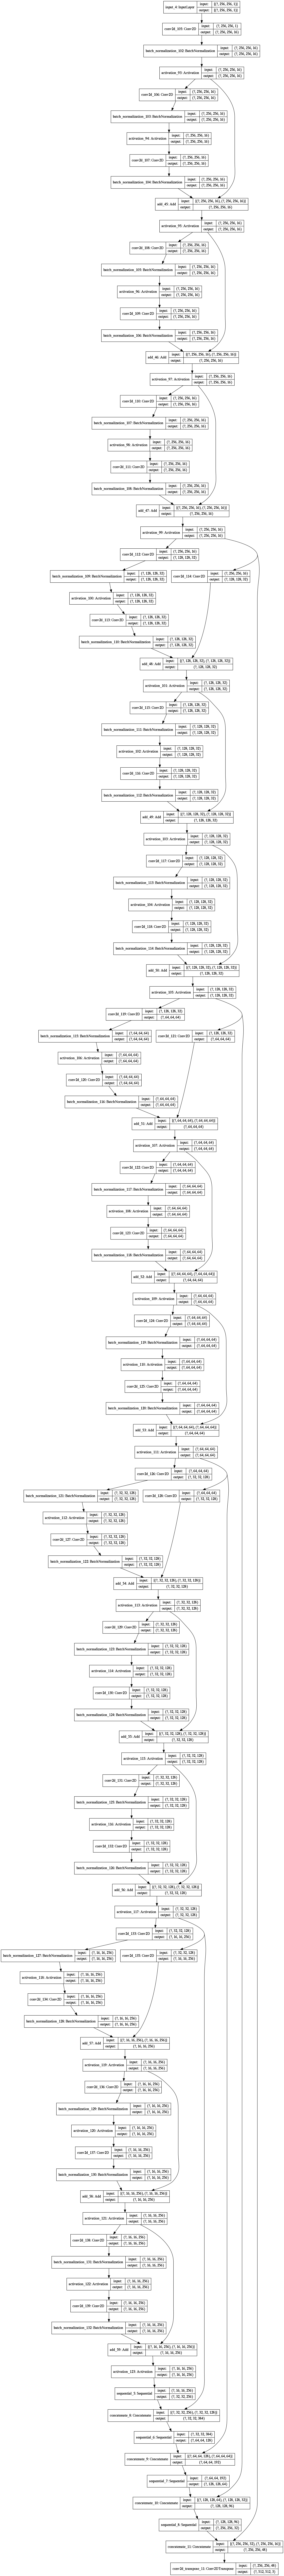

In [51]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [37]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    print(tf.shape(pred_mask[0]))
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for frame, mask in dataset.take(num):
            pred_mask = model.predict(frame)
            display([frame[0], mask[0], create_mask(pred_mask)])
    else:
        predicted = model.predict(sample_frame[tf.newaxis, ...])
        print(tf.shape(predicted))
        display([sample_frame, sample_mask,
                create_mask(predicted)])

tf.Tensor([  1 512 512   3], shape=(4,), dtype=int32)
tf.Tensor([512 512   1], shape=(3,), dtype=int32)


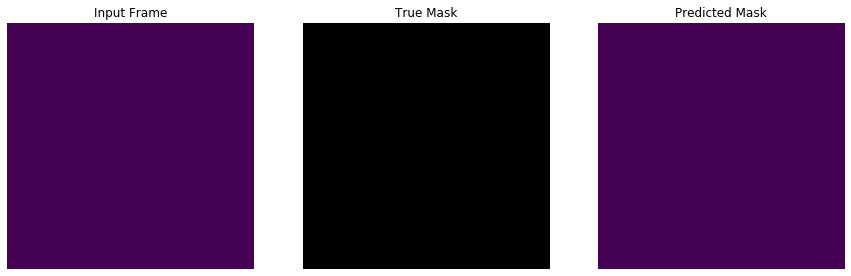

In [38]:
show_predictions()